In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from comparison import ForecastToObsAlignment, Comparison

### Checking the constructed observations

In [2]:
basepath = Path('/nobackup/users/straaten/ERA5/')
hotpath = basepath / 'tg-ex-q0.75-4D_1998-06-07_2019-08-31_1D_15-t2m-q095-adapted-mean.nc'
clusterpath = basepath / 'tg-anom_2000-01-01_2000-02-01_1D_15-t2m-q095-adapted-mean.nc'

In [3]:
clusters = xr.open_dataset(clusterpath)['clustidfield']

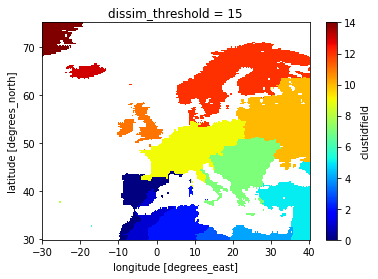

In [4]:
clusters.plot(cmap = 'jet')

cluster 6 and 8 are almost gridpoints.

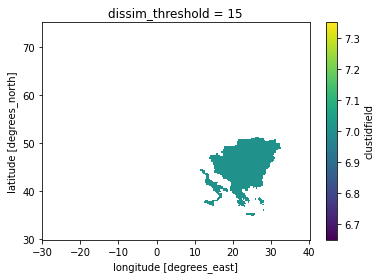

In [5]:
clusters.where(clusters == 7, np.nan).plot()

In [6]:
da = xr.open_dataarray(hotpath)

In [7]:
df = da.to_dataframe().unstack(-1)

array([[<AxesSubplot:title={'center':"('tg-ex-q0.75-4D', 10)"}>,
        <AxesSubplot:title={'center':"('tg-ex-q0.75-4D', 12)"}>],
       [<AxesSubplot:title={'center':"('tg-ex-q0.75-4D', 14)"}>,
        <AxesSubplot:>]], dtype=object)

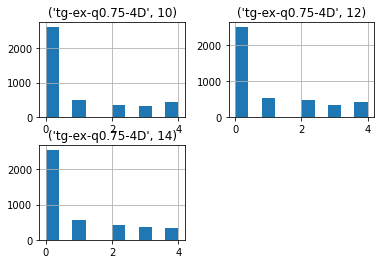

In [8]:
df.loc[slice(None,'2010-01-01'),(slice(None),[10,12,14])].hist()

<AxesSubplot:title={'center':'frequency of 4 day episodes per year'}, xlabel='time'>

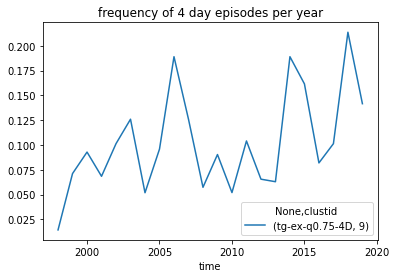

In [9]:
(df.loc[:,(slice(None),9)] == 4).groupby(df.index.year).apply(lambda d: d.sum()/d.count()).plot(title = 'frequency of 4 day episodes per year')

<AxesSubplot:title={'center':'frequency of 0 day episodes per year'}, xlabel='time'>

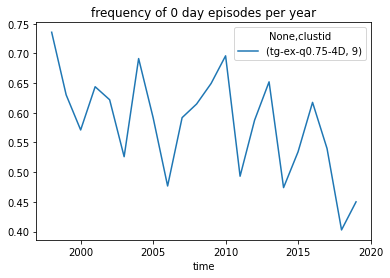

In [10]:
(df.loc[:,(slice(None),9)] == 0).groupby(df.index.year).apply(lambda d: d.sum()/d.count()).plot(title = 'frequency of 0 day episodes per year')

Trending behaviour is as expected. As temperatures rise (and we have a fixed quantile threshold in time) it will happen more often. So less non-occurrences, more chance of multiple occurrences (supposing probabilities are independent day-to-day). Noisy of course, and the first and last years are incomplete.

Quantile dependence on season should show that distribution is equal over the year.

<AxesSubplot:xlabel='time'>

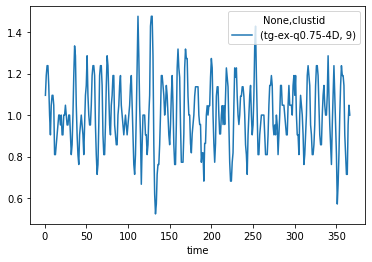

In [50]:
df.loc[:,(slice(None),9)].groupby(df.index.day_of_year).mean().plot()

### Checking a 7day match
this variable has 7 options. What would be a good categorical split? Perhaps first binary, like >= 3

In [25]:
bookfile = 'books_paper3-2_tg-ex-q0.75-7D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv'

In [26]:
al = ForecastToObsAlignment('JJA','45r1')
al.recollect(booksname = bookfile)
df = al.alignedobject.compute()

array([[<AxesSubplot:title={'center':"('forecast', 0)"}>,
        <AxesSubplot:title={'center':"('forecast', 1)"}>]], dtype=object)

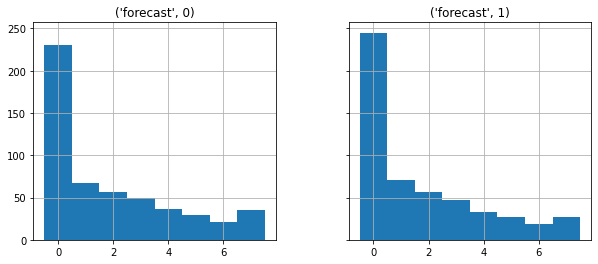

In [72]:
df.loc[np.logical_and(df['clustid'] == 9, df['leadtime'] == 1),('forecast',[0,1])].hist(sharey = True, bins = np.arange(-0.5,8.5), figsize = (10,4))

In [75]:
(df.loc[np.logical_and(df['clustid'] == 9, df['leadtime'] == 1),'observation'] >= 3).mean()

number
0    0.293333
dtype: float64

In [2]:
#TODO Check if this can be handled inside the Comparison framework. needs a climatology. Problem is that the probabilistic climatology file would need to change per nday_threshold
# days > q0.75 within 7 
def transform_and_bs(frame: pd.DataFrame, nday_threshold: int = 3):
    """
    A computed aligned frame. returns it with a pi, pi_bs and clim_bs column. 
    Pi is for positive case so chance of >= nday_threshold
    """
    test = frame.copy()
    test['pi'] = (test['forecast'].values >= nday_threshold).sum(axis = 1) / test['forecast'].shape[-1]
    test['observation'] = test['observation'].values >= nday_threshold
    clim_chances = test.groupby('clustid').mean()['observation'] # Assume there is little leadtime dependence (pooling these for a smoother estimate)
    clim_chances.columns = pd.MultiIndex.from_tuples([('climatology','')])
    test = test.merge(clim_chances, on = 'clustid')
    for key in ['pi','climatology']:
        bs = (test[key].values.squeeze() - test['observation'].values.squeeze())**2
        scorename = f'{key}_bs'
        test[scorename] = bs
    return test

In [77]:
test = transform_and_bs(df)
test = test.groupby(['clustid','leadtime']).mean()
test['bss'] = 1 - test['pi_bs']/test['climatology_bs']
test = test.unstack(0) # column levels are e.g. obs, member, clustid

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<AxesSubplot:xlabel='leadtime'>

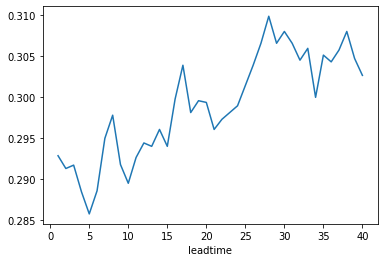

In [60]:
test.loc[:,('pi','',11)].plot() # Interestingly cluster 11 has a drift to more frequent occurrence.

<AxesSubplot:xlabel='leadtime'>

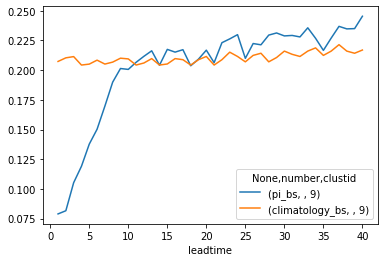

In [61]:
test.loc[:,(['pi_bs','climatology_bs'], slice(None),9)].plot()

When normalized I think that all regions go to negative skill at the final lead times. This probably has to do with the fact that drift in spread is not corrected for (would require leadtime dependent quantile climatology).

Also interesting is the clusters 6 and 8, with an initial increase in skill with lead time. When checking the clusterarray it appeared that these clusters are ... almost as small as gridpoints. Interesting is also that skill for 10 (great brittain) > skill for 9 (west and central europe).

<AxesSubplot:xlabel='leadtime'>

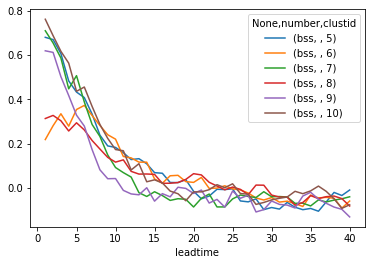

In [108]:
test.sort_index(axis = 1).loc[:,('bss',slice(None),slice(5,10))].plot()

More than 2 hotdays is already a less frequent part of the data. Skill is present and compares with the first paper estimates. Leadtime here is not untill midpoint but till the first day.

In [3]:
def rank_hist(frame):
    """
    Computes the placement of the observation in the n ordered forecast members.
    n+1 options.
    Have to deal with being a discrete variable. possibility of everything being equal.
    """
    frame = frame.copy()
    n_members = frame['forecast'].shape[-1]
    noisy_for = frame['forecast'].values + np.random.normal(scale = 0.001, size = frame['forecast'].shape)
    noisy_obs = frame['observation'].values + np.random.normal(scale = 0.001, size = frame['observation'].shape)
    #noisy obs = frame['observation'].values
    n_higher = (noisy_for > noisy_obs).sum(axis = 1)
    #all_equal = (frame['forecast'] == frame['observation'].values).all(axis = 1)
    frame['placement'] = (-n_higher) + n_members + 1 # placement in the order. if 0 higher than place n+1,
    #frame['equal'] = all_equal
    bin_edges = np.arange(1 - 0.5, n_members + 1 + 1 + 0.5) # from min (1) to max (12) + 1, both +- 0.5. Max is plus 2 because of np.arange non-inclusive stops
    ax = frame['placement'].hist(bins = bin_edges)
    return ax

<AxesSubplot:>

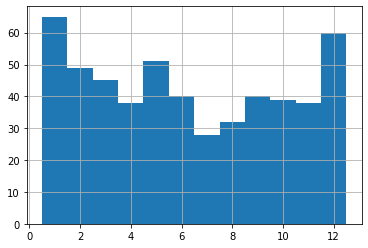

In [84]:
rank_hist(df.loc[np.logical_and(df['clustid'] == 9, df['leadtime'] == 1),:])

<AxesSubplot:>

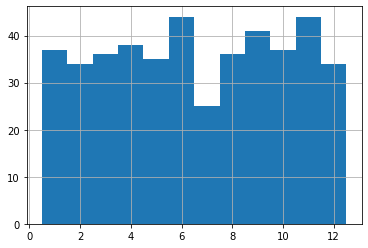

In [36]:
rank_hist(df.loc[np.logical_and(df['clustid'] == 9, df['leadtime'] == 40),:])

Beware that some randomness is involved in the rank histograms. Underdispersion seems to disappear a bit with increasing leadtime (>5 days).

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


<AxesSubplot:xlabel='time'>

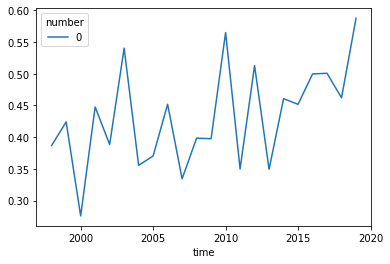

In [109]:
temp = transform_and_bs(df,nday_threshold=2)
temp['observation'].groupby(temp['time'].dt.year).mean().plot()

## Lets compare this to the skill of raw 7D average temperature
Perhaps this is less calibrated. I.e. the freedom of timing enables the model to be better calibrated by itself right in contrast to the latter.

In [69]:
al = ForecastToObsAlignment('JJA','45r1')
al.recollect('books_paper3-1_tg-anom_JJA_45r1_7D-roll-mean_15-t2m-q095-adapted-mean.csv')
df2 = al.alignedobject.compute()

<AxesSubplot:>

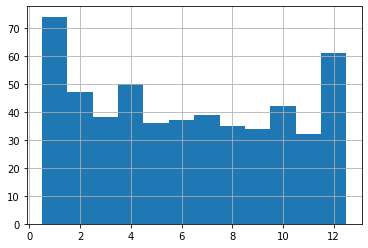

In [81]:
rank_hist(df.loc[np.logical_and(df['clustid'] == 9, df['leadtime'] == 1),:])

In [85]:
df2

time clustid leadtime  forecast                                \
number                                     0         1         2         3   
0      1998-06-07       0        1 -0.976052 -1.238917 -1.296430 -1.454579   
1      1998-06-07       1        1 -0.213306 -0.227214 -0.411195 -0.264104   
2      1998-06-07       2        1 -1.407711 -1.058423 -1.640739 -1.034321   
3      1998-06-07       3        1 -0.353031 -0.293428 -0.610444  0.025406   
4      1998-06-07       4        1 -0.061941 -0.068480 -0.195310 -0.067422   
..            ...     ...      ...       ...       ...       ...       ...   
10     2019-06-24      10       40  5.531879  0.375401  2.005050  1.514319   
11     2019-06-24      11       40 -1.993593  1.191616 -0.065167 -1.575926   
12     2019-06-24      12       40  2.372827  3.919668  0.340384 -0.923868   
13     2019-06-24      13       40  0.498339  0.146235  0.993038 -1.260409   
14     2019-06-24      14       40 -0.045232  0.172332  1.158273 -0.518335   

                                                                              \
number         4         5         6         7         8         9        10   
0      -1.021527 -1.255540 -1.204572 -1.669486 -1.061794 -0.856455 -1.416008   
1      -0.120398 -0.356656 -0.275581 -0.679596 -0.196251  0.034227 -0.247906   
2      -1.201391 -1.540933 -1.407783 -2.042886 -1.229532 -0.725525 -0.974509   
3      -0.594866 -0.375380 -0.279578 -0.406628 -0.477701 -0.228862 -0.045974   
4      -0.343437 -0.085265 -0.210367 -0.216748 -0.276536 -0.215210 -0.106289   
..           ...       ...       ...       ...       ...       ...       ...   
10      0.741613  0.710156  6.555672  2.768505 -0.709744  4.156024  0.123175   
11     -2.156291  3.566559 -1.181508 -2.175850  1.039304 -0.475917 -0.307713   
12      0.766953  0.971622  0.937574  2.458957 -0.485667  3.194347 -0.042183   
13     -1.271245 -0.323766  0.581901  0.074876  2.623209 -2.432975  4.597348   
14     -0.022202 -1.294161 -1.072204  1.457346 -0.853901 -1.151678  3.777611   

       observation  
number           0  
0        -0.032437  
1         0.975941  
2        -0.655744  
3         0.366586  
4         1.395283  
..             ...  
10       -0.137700  
11        2.070135  
12       -0.792829  
13        1.743777  
14        2.153450  

[273420 rows x 15 columns]

Rank histograms are actually pretty comparable. 
brier score computation in the Prelim_skill notebook. For 7Day > q0.75 the bs seems to level of < 10 days. (When using a dedicated model climatology). I would say that therefore the 'timing insitive hotdays' have a potential to be more skillful.

## Compare against 14day exceedence.

In [6]:
bookfile2 = 'books_paper3-2_tg-ex-q0.75-14D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv'

In [7]:
al = ForecastToObsAlignment('JJA','45r1')
al.recollect(booksname = bookfile2)
df2 = al.alignedobject.compute()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

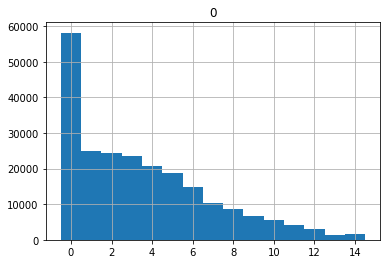

In [8]:
df2['observation'].hist(bins = np.arange(-0.5,15.5))

In [107]:
(df2.loc[np.logical_and(df2['clustid'] == 5, df2['leadtime'] == 1),'observation'] >= 7).mean()

number
0    0.215238
dtype: float64

<AxesSubplot:>

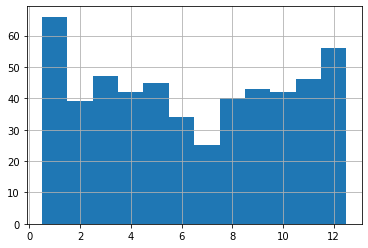

In [91]:
rank_hist(df2.loc[np.logical_and(df2['clustid'] == 9, df2['leadtime'] == 1),:])

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


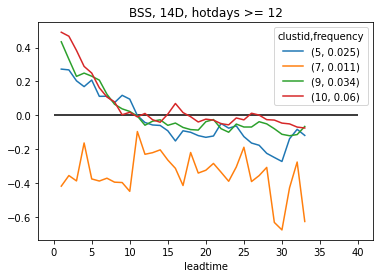

In [13]:
nday2 = 12
clustids = [5,7,9,10]
test2 = transform_and_bs(df2, nday_threshold = nday2)
frequencies2 = test2.groupby('clustid').mean().loc[:,('observation',0)]
test2 = test2.groupby(['clustid','leadtime']).mean().loc[(clustids,slice(None)),:]
test2['bss'] = 1 - test2['pi_bs']/test2['climatology_bs']
score2 = test2.unstack(0)[('bss','')] # column levels are e.g. obs, member, clustid
score2.columns = pd.MultiIndex.from_arrays([score2.columns, frequencies2.loc[clustids].round(3).values], names = ['clustid','frequency'])
score2.plot(title = f'BSS, 14D, hotdays >= {nday2}')
plt.hlines(0,0,40, color = 'black')

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


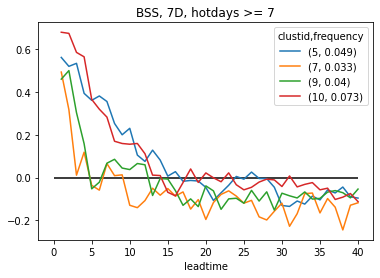

In [11]:
nday = 7
test = transform_and_bs(df, nday)
frequencies = test.groupby('clustid').mean().loc[:,('observation',0)]
test = test.groupby(['clustid','leadtime']).mean().loc[(clustids,slice(None)),:]
test['bss'] = 1 - test['pi_bs']/test['climatology_bs']
score = test.unstack(0)[('bss','')] # column levels are e.g. obs, member, clustid
score.columns = pd.MultiIndex.from_arrays([score.columns, frequencies.loc[[5,7,9,10]].round(3).values], names = ['clustid','frequency'])
score.plot(title = f'BSS, 7D, hotdays >= {nday}')
plt.hlines(0,0,40, color = 'black')

## Compare against 21day exceedence.
This matched set has 

In [4]:
bookfile3 = 'books_paper3-2_tg-ex-q0.75-21D_JJA_45r1_1D_15-t2m-q095-adapted-mean.csv'

In [5]:
al = ForecastToObsAlignment('JJA','45r1')
al.recollect(booksname = bookfile3)
df3 = al.alignedobject.compute()

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/IPython/core/interactiveshell.py:2898: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


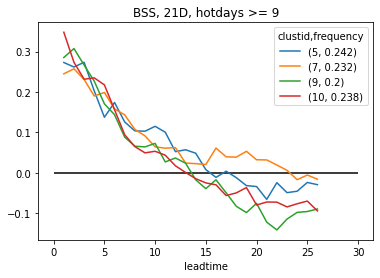

In [37]:
nday3 = 9
clustids = [5,7,9,10]
test3 = transform_and_bs(df3, nday_threshold = nday3)
frequencies3 = test3.groupby('clustid').mean().loc[:,('observation',0)]
test3 = test3.groupby(['clustid','leadtime']).mean().loc[(clustids,slice(None)),:]
test3['bss'] = 1 - test3['pi_bs']/test3['climatology_bs']
score3 = test3.unstack(0)[('bss','')] # column levels are e.g. obs, member, clustid
score3.columns = pd.MultiIndex.from_arrays([score3.columns, frequencies3.loc[clustids].round(3).values], names = ['clustid','frequency'])
score3.plot(title = f'BSS, 21D, hotdays >= {nday3}')
plt.hlines(0,0,30, color = 'black')

So suddenly the 7D cluster is doing quite good and 10 need not dominate 9. 7 also has less model drift compared to the other clusters.
Interestingly for hotdays >= we see a bad performance for some clusters. Meaning that a few cold cases (negative observations) are missed?

<AxesSubplot:title={'center':'21day hotdays control and ensmean drift'}, xlabel='leadtime'>

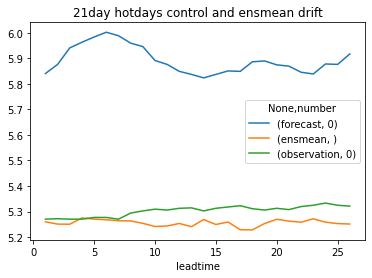

In [43]:
localset = df3.loc[df3['clustid'] == 7,:]
localset = localset.assign(ensmean = localset['forecast'].mean(axis = 1))
per_leadtime = localset.groupby(localset['leadtime']).mean()
per_leadtime[[('forecast',0),('ensmean',''),('observation',0)]].plot(title = '21day hotdays control and ensmean drift')